## Tesla Stock Price Prediction, 365 Days
### Second Semester Capstone

This is the same as the "Semester Start" notebook, but now I'm making a 365 day prediction. I've also added a section for finding the quarterly maximums and adding those maximums to the prediction chart.  This is a prediction of Tesla stock price. I use Trump and Elon Musk tweet data as part of the prediction. I did some low effort sentiment analysis using the nlkt Python library (nltk = Natural Language Toolkit) and the VADER pre-trained sentiment analysis tool. I also make my own attempt at analysis of the tweets by seeing whether they contain some Tesla-related keywords.

In [80]:
import nltk
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot

In [81]:
from nltk.sentiment import SentimentIntensityAnalyzer
from statistics import mean
sia = SentimentIntensityAnalyzer()

# These are the functions for the sentiment analysis. 
# is_positive uses the pre-made SentimentIntensityAnalyzer that's a part of the nltk library.
def is_positive(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    scores = [sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(tweet)]
    return mean(scores) > 0

# contains_tesla returns positive if the tweet contains any of the words or phrases in the "search" list.
def contains_tesla(tweet: str) -> bool:
    search = ("tesla", "tsla", "cybertruck", "model s", "model x", "model 3", "model y", "electric car", "electric cars")
    return any(word in tweet.lower() for word in search)

In [82]:
df_trump = pd.read_csv("Data/trump_tweets.csv", parse_dates = ['date'], index_col=7)
# Applying the sentiment analysis functions to the trump data
df_trump["Trump Positive Sentiment"] = df_trump.apply(lambda row: is_positive(row["text"]), axis = 1)
df_trump["Trump Contains Tesla"] = df_trump.apply(lambda row: contains_tesla(row["text"]), axis=1)
print(df_trump.shape)
df_trump.head()

(56571, 10)


,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged,Trump Positive Sentiment,Trump Contains Tesla
date,,,,,,,,,,
2009-05-04 18:54:00,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,f,True,False
2009-05-05 01:00:00,1.701461e+09,Donald Trump will be appearing on The View tom...,f,f,Twitter Web Client,259,34,f,True,False
2009-05-08 13:38:00,1.737480e+09,Donald Trump reads Top Ten Financial Tips on L...,f,f,Twitter Web Client,37,15,f,True,False
2009-05-08 20:40:00,1.741161e+09,New Blog Post: Celebrity Apprentice Finale and...,f,f,Twitter Web Client,29,11,f,False,False
2009-05-12 14:07:00,1.773561e+09,"""""""My persona will never be that of a wallflow...",f,f,Twitter Web Client,1877,1321,f,False,False


In [83]:
df_musk = pd.read_csv("Data/musk_2021.csv", parse_dates = ['date'], index_col=0)
# The csv is indexed by id, we want it indexed by date
df_musk.set_index("date", inplace=True)
df_musk.sort_index(ascending=True, inplace=True)
df_musk["Musk Positive Sentiment"] = df_musk.apply(lambda row: is_positive(row["tweet"]), axis = 1)
df_musk["Musk Contains Tesla"] = df_musk.apply(lambda row: contains_tesla(row["tweet"]), axis=1)
print(df_musk.shape)
df_musk.head()

(12339, 39)


,id,conversation_id,created_at,timezone,place,tweet,language,hashtags,cashtags,user_id,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Musk Positive Sentiment,Musk Contains Tesla
date,,,,,,,,,,,,,,,,,,,,,
2010-06-04 18:31:57,15434727182,15434727182,1.275676e+12,0,NaN,"Please ignore prior tweets, as that was someon...",en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False
2011-12-01 09:55:11,142179928203460608,142179928203460608,1.322733e+12,0,NaN,Went to Iceland on Sat to ride bumper cars on ...,en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False
2011-12-01 10:29:04,142188458125963264,142188458125963264,1.322735e+12,0,NaN,I made the volume on the Model S http://t.co/...,en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,False,True
2011-12-03 08:20:28,142880871391838208,142880871391838208,1.322900e+12,0,NaN,"Great Voltaire quote, arguably better than Twa...",en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False
2011-12-03 08:22:07,142881284019060736,142881284019060736,1.322901e+12,0,NaN,That was a total non sequitur btw,en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,False,False


In [84]:
df_tsla = pd.read_csv("Data/TSLA.csv", parse_dates=['Date'], index_col=0)
print(df_tsla.shape)
df_tsla.head()

(2856, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500


# LSTM Application

## Function For Converting Time Series Data For Supervised Learning

In [85]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

### Trimming and merging dataframes

In [86]:
# Aligning Tweet Data with Doge Data
df_musk = df_musk.loc[(df_musk.index >= '2010-06-30')]
# Dropping columns that are not expected to be useful
df_musk = df_musk.drop(columns=[
    'id', 'conversation_id', 'timezone', 'place',
    'language', 'user_id', 'geo', 'source', 'user_rt_id',
    'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
    'translate', 'trans_src', 'trans_dest', 'user_id_str',
    'username', 'name', 'day', 'hour', 'link', 'urls',
    'photos', 'video', 'thumbnail', 'retweet', 'quote_url',
    'search', 'near', 'created_at', 'tweet', 'hashtags',
    'cashtags'
], axis=1)

# Changing by-the-second data to by-the-day data
changed1 = df_musk.groupby([df_musk.index.date]).size().reset_index(name='Musk Tweet Count')
changed2 = df_musk.groupby([df_musk.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_musk = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_musk = df_musk.rename_axis('Date')
df_musk.rename(columns={"nlikes": "Musk Likes", "nreplies": "Musk Replies", "nretweets": "Musk Retweets"}, inplace=True)
df_musk["Musk Negative Sentiment"] = df_musk["Musk Tweet Count"] - df_musk["Musk Positive Sentiment"]
print(df_musk.shape)
df_musk.head(10)

(2004, 7)


,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Musk Positive Sentiment,Musk Contains Tesla,Musk Negative Sentiment
Date,,,,,,,
2011-12-01,2,267,63,24,1,1,1
2011-12-03,2,82,38,31,1,0,1
2011-12-04,1,65,17,9,1,0,0
2011-12-21,7,1330,87,597,5,0,2
2011-12-22,3,1349,132,206,1,1,2
2011-12-24,3,117113,1370,8434,2,0,1
2011-12-26,6,558,102,171,3,0,3
2011-12-27,1,39,13,34,1,0,0
2011-12-28,1,12,7,1,1,0,0


In [87]:
# Aligning Tweet Data with Doge Data
df_trump = df_trump.loc[(df_trump.index >= '2010-06-30')]
# Dropping ID column since it's unexpected to be useful
df_trump = df_trump.drop(columns=['id'], axis=1)

# Changing by-the-second data to by-the-day data
changed1 = df_trump.groupby([df_trump.index.date]).size().reset_index(name='Trump Tweet Count')
changed2 = df_trump.groupby([df_trump.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_trump = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_trump = df_trump.rename_axis('Date')
df_trump.rename(columns={"favorites": "Trump Favorites", "retweets": "Trump Retweets"}, inplace=True)
df_trump["Trump Negative Sentiment"] = df_trump["Trump Tweet Count"] - df_trump["Trump Positive Sentiment"]

print(df_trump.shape)
df_trump.head()

(3390, 6)


,Trump Tweet Count,Trump Favorites,Trump Retweets,Trump Positive Sentiment,Trump Contains Tesla,Trump Negative Sentiment
Date,,,,,,
2010-07-01,1,16,27,0,0,1
2010-07-02,2,36,78,2,0,0
2010-07-06,1,6,47,0,0,1
2010-07-14,1,48,89,1,0,0
2010-07-19,3,11,37,1,0,2


In [88]:
# Aligning tsla Data with Tweet Data
df_tsla = df_tsla.loc[(df_tsla.index <= '2021-03-22')]
print(df_tsla.shape)

(2700, 6)


In [89]:
# Merging Two Data Sets Together
df = df_tsla.merge(df_musk, how='outer', left_index=True, right_index=True)
df = df.merge(df_trump, how='outer', left_index=True, right_index=True)
# As part of the merge we get some NA values, We want to replace those with a value of '0'
df[['Musk Tweet Count', 'Musk Likes', 'Musk Replies', 'Musk Retweets', 'Musk Positive Sentiment', \
        'Musk Contains Tesla', 'Musk Negative Sentiment', 'Trump Tweet Count', 'Trump Favorites', 'Trump Retweets', \
        'Trump Positive Sentiment', 'Trump Contains Tesla', 'Trump Negative Sentiment']] \
    = df[['Musk Tweet Count', 'Musk Likes', 'Musk Replies', 'Musk Retweets', 'Musk Positive Sentiment', \
            'Musk Contains Tesla', 'Musk Negative Sentiment', 'Trump Tweet Count', 'Trump Favorites', 'Trump Retweets', \
            'Trump Positive Sentiment', 'Trump Contains Tesla', 'Trump Negative Sentiment']].fillna(0)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Musk Positive Sentiment,Musk Contains Tesla,Musk Negative Sentiment,Trump Tweet Count,Trump Favorites,Trump Retweets,Trump Positive Sentiment,Trump Contains Tesla,Trump Negative Sentiment
Date,,,,,,,,,,,,,,,,,,,
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0,27.0,0.0,0.0,1.0
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,36.0,78.0,2.0,0.0,0.0
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,47.0,0.0,0.0,1.0
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Converting Data for Supervised Learning

In [90]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,19]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()


(2206, 20)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var2(t)
1,0.002173,0.003074,0.001916,0.001825,0.001825,0.280640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.002071
2,0.001995,0.002071,0.001218,0.001400,0.001400,0.133184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00625,1.954631e-06,0.000011,0.000000,0.0,0.011236,0.001442
3,0.001545,0.001442,0.000859,0.000773,0.000773,0.082560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01250,4.397919e-06,0.000031,0.021053,0.0,0.000000,0.000751
4,0.000869,0.000751,0.000196,0.000070,0.000070,0.110956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00625,7.329866e-07,0.000019,0.000000,0.0,0.011236,0.000000
5,0.000059,0.000000,0.000000,0.000000,0.000000,0.111857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000198


## Running Model

In [91]:
values = reframed.values
# split into train, test, and prediction sets
#n_predict = floor((len(values) * 0.10))
n_predict = 365
n_train = floor((len(values) * 0.80))
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :]
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1764, 1, 19) (1764,) (77, 1, 19) (77,) (365, 1, 19) (365,)


In [92]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.callbacks import Callback

# Unused
class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 0.009 #Assign THR with the value at which you want to stop training.
            if logs.get('loss') <= THR:
                 self.model.stop_training = True

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                14000     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 14,051
Trainable params: 14,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
4/4 - 1s - loss: 0.0342 - accuracy: 5.6689e-04 - val_loss: 0.0497 - val_accuracy: 0.0000e+00
Epoch 2/150
4/4 - 0s - loss: 0.0280 - accuracy: 5.6689e-04 - val_loss: 0.0395 - val_accuracy: 0.0000e+00
Epoch 3/150
4/4 - 0s - loss: 0.0248 - accuracy: 5.6689e-04 - val_loss: 0.0309 - val_accuracy: 0.0000e+00
Epoch 4/150
4/4 - 0s - loss: 0.0221 - accuracy: 5.6689e-04 - val_loss: 0.0234 - val_accuracy: 0.0000e+00
Epoch 5/150
4/4 - 0s - loss: 0.0200 - accuracy: 5.6689e-04 - val_loss: 0.0170 - val_accurac

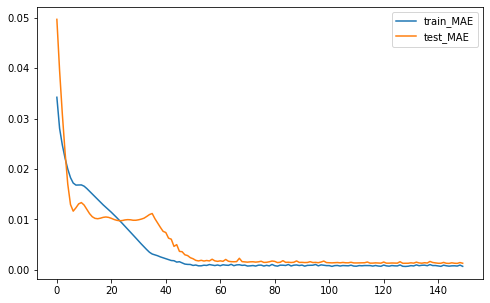

In [125]:
# Design Network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=450, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.show()

### Prediction

In [126]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Metrics

In [127]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(mean(inv_y))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 14.820
Normalized RMSE: 0.055


In [128]:
# Finding the predicted quarterly maximums
dates = df.index.to_numpy()
dates = dates[len(dates)-n_predict:]

maxes = [
    dates[np.argmax(yhat[0:89], axis=0)], 
    dates[np.argmax(yhat[90:179], axis=0)+90], 
    dates[np.argmax(yhat[180:269], axis=0)+180], 
    dates[np.argmax(yhat[270:364], axis=0)+270]
]
maxes_actual = [
    dates[np.argmax(predict_y[0:89], axis=0)], 
    dates[np.argmax(predict_y[90:179], axis=0)+90], 
    dates[np.argmax(predict_y[180:269], axis=0)+180], 
    dates[np.argmax(predict_y[270:364], axis=0)+270]
]

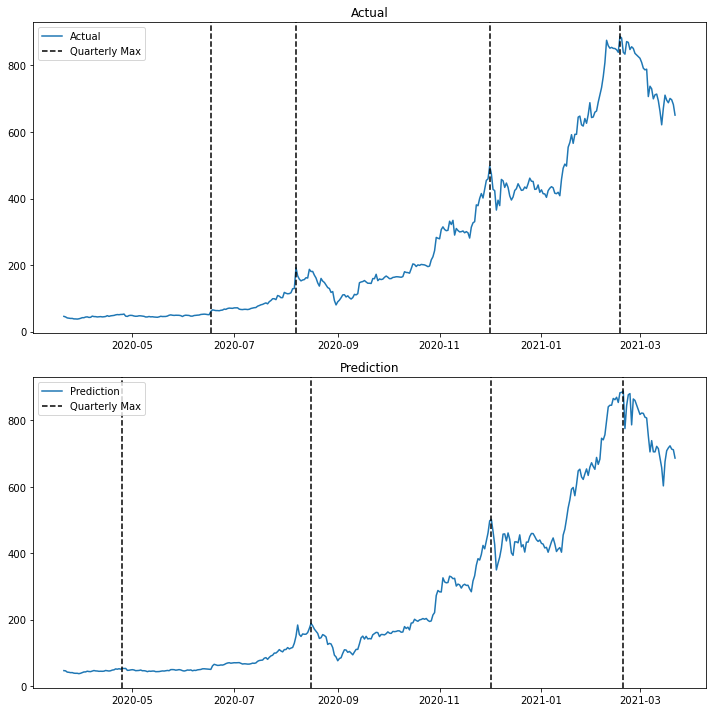

In [129]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,10))

pyplot.subplot(2, 1, 1)
pyplot.plot(dates, inv_y, label="Actual")
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='k', linestyle='--', label='Quarterly Max')
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='k', linestyle='--')
pyplot.legend(loc='upper left')
pyplot.title("Actual")

pyplot.subplot(2, 1, 2)
pyplot.plot(dates, inv_yhat, label="Prediction")
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='k', linestyle='--', label='Quarterly Max')
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='k', linestyle='--')
pyplot.legend(loc='upper left')
pyplot.title("Prediction")

pyplot.tight_layout()
pyplot.show()

In [130]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i][0]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i][0]))
    print("Diff: %s" %abs((maxes_actual[i][0]-maxes[i][0]).astype('timedelta64[D]')))

Q1 Max: 2020-04-25T00:00:00.000000000
Q1 Actual Max: 2020-06-17T00:00:00.000000000
Diff: 53 days
Q2 Max: 2020-08-16T00:00:00.000000000
Q2 Actual Max: 2020-08-07T00:00:00.000000000
Diff: 9 days
Q3 Max: 2020-12-02T00:00:00.000000000
Q3 Actual Max: 2020-12-01T00:00:00.000000000
Diff: 1 days
Q4 Max: 2021-02-19T00:00:00.000000000
Q4 Actual Max: 2021-02-17T00:00:00.000000000
Diff: 2 days


In [131]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,19)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


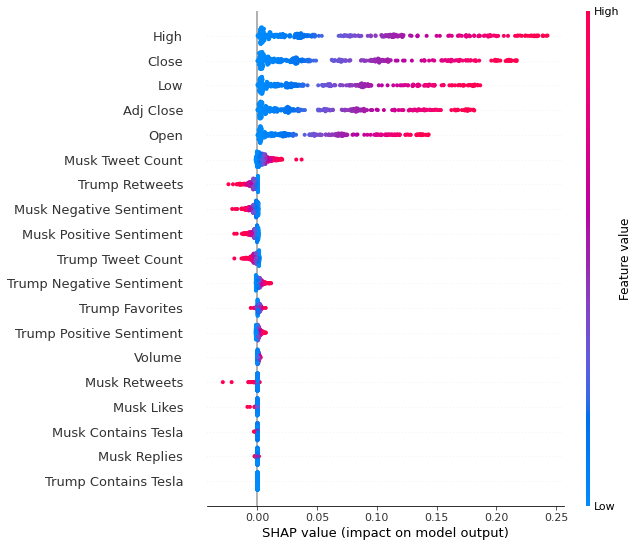

In [132]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)